In [7]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
import re
import torch
from PIL import Image

load_dotenv()

PROJECT_DIR = os.getenv("PROJECT_DIR")
DEAL_ANNOTATION_PATH = os.path.join(PROJECT_DIR, "labeled_deals_gabriel.csv")
LEAFLET_DIR = os.path.join(PROJECT_DIR, "crawled_leaflets")
DABASE_PATH = os.path.join(LEAFLET_DIR, "supermarket_leaflets.db")
DEALS_DIR = os.path.join(PROJECT_DIR, "deals")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")

In [8]:
all_images = []

for root, dirs, files in os.walk(DEALS_DIR):
    for file in files:
        if file.endswith(".png") and "annotated" not in file:
            all_images.append(os.path.join(root, file))

In [ ]:
processor = DonutProcessor.from_pretrained(os.path.join(MODELS_DIR, "donut_deal_processor"))
model = VisionEncoderDecoderModel.from_pretrained(os.path.join(MODELS_DIR, "donut_deal_model"))

def out_to_dict(seq):
    _dict = {}
    # extract all attributes from the sequence (<s_{attribute}>value</s_{attribute}>)
    for match in re.finditer(r"<s_(.*?)>(.*?)</s_(.*?)>", seq):
        _dict[match.group(1)] = match.group(2)
    return _dict

Prediction: {'brand': ' Bioland', 'productname': ' Alnagona', 'original_price': ' 1. 29', 'weight': ' 45. 5l'}


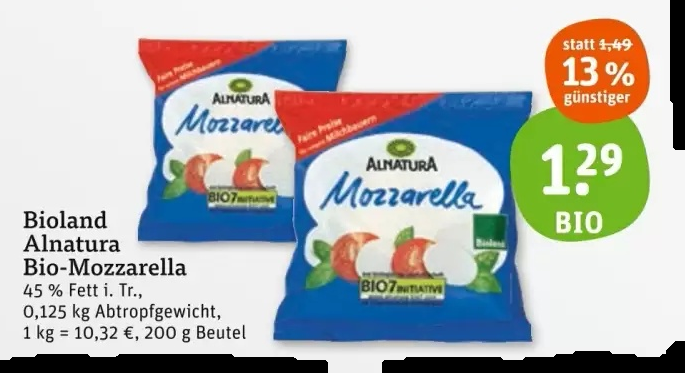

In [ ]:
rnd_image = np.random.choice(all_images)

img = Image.open(rnd_image).convert("RGB")

pixel_values = processor(img, return_tensors="pt").pixel_values
decoder_input_ids = torch.full(
    (1, 1), model.config.decoder_start_token_id
)

outputs = model.generate(
    pixel_values,
    decoder_input_ids=decoder_input_ids,
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=3,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

predictions = []
for seq in processor.tokenizer.batch_decode(outputs.sequences):
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(
        processor.tokenizer.pad_token, ""
    ).replace("<s_cord-v2>", "").replace("</s_cord-v2>", "")
    predictions.append(seq)

print(f"Prediction: {out_to_dict(predictions[0])}")
img